## Tuning Tolerance

(Experimentation playground for CLI tune command. See `abfs tune -h` for running this command.)

In [1]:
from collections import namedtuple as Struct
from toolz import curry, topk, second
from time import time

import matplotlib.pyplot as plt
import numpy as np
import cv2

import abfs.cli
import abfs.keras.metrics

import tensorflow as tf

CLIParams = Struct('CLIParams', [
    'weights_path', 'size',
    'epochs', 'gpu_count', 'learning_rate', 'max_batches', 'batch_size'
])

params = CLIParams(
    'checkpoints/<INSERT WEIGHTS HERE>.hdf5', 512,
    None, 2, 0, 9999999, 99999998
)

u_net = abfs.cli.model(params)

print(f'Batch Count: {len(u_net.val_generator)}')

Using TensorFlow backend.


Batch Count: 1


In [2]:
images, truth_masks = u_net.val_generator.__getitem__(0)

print(f'Tuning of the tolerance parameter will occur on {images.shape[0]} images')

Tuning of the tolerance parameter will occur on 431 images


In [3]:
predictions = u_net.model.predict(images)

Loading weights from checkpoints/<INSERT WEIGHTS HERE>.hdf5


## Sample Tolerance

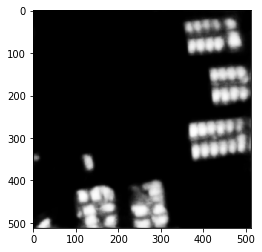

In [4]:
%matplotlib inline

plt.imshow(np.squeeze(predictions[0]), cmap='gray')
plt.show()

Using a sample threshold of 0.5, here's the associated mask.

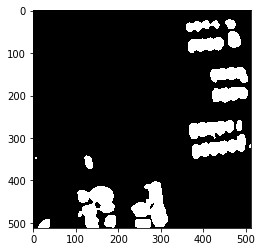

In [11]:
_, threshold = cv2.threshold(predictions[0], 1 - 0.5, 1, cv2.THRESH_BINARY)
plt.imshow(np.squeeze(threshold), cmap='gray')
plt.show()

In [6]:
tf.InteractiveSession()

abfs.keras.metrics.fbeta_score(
    tf.stack(np.squeeze(truth_masks[0].astype(np.float32))),
    tf.stack(np.squeeze(threshold.astype(np.float32)))
).eval()

0.68761516

## Tuning

In [7]:
combined = np.array(list(zip(truth_masks, predictions)))

def threshold_tf(prediction, tolerance):
    return tf.cast(prediction > (1 - tolerance), tf.float32)

@curry
def f1_score_tf(tolerance, truth_mask_and_prediction):
    truth_mask = truth_mask_and_prediction[0]
    prediction_mask = threshold_tf(tolerance, truth_mask_and_prediction[1])
    
    return abfs.keras.metrics.fbeta_score(
        tf.squeeze(tf.cast(truth_mask, tf.float32)),
        tf.squeeze(prediction_mask)
    )

@curry
def f1_scores_tf(truth_masks_and_predictions, tolerance):
    return tf.map_fn(f1_score_tf(tolerance), truth_masks_and_predictions)

def f1_scores_per_tolerances_tf(tolerances, truth_masks_and_predictions):
    return tf.map_fn(f1_scores_tf(truth_masks_and_predictions), tolerances)

start = time()

TOLERANCES = np.linspace(0.02, 1, 50)

results = f1_scores_per_tolerances_tf(
    tf.constant(TOLERANCES, tf.float32),
    tf.stack(combined)
).eval()

print(f'Duration: {time() - start}')

Duration: 7.609090566635132


In [8]:
results.shape

(50, 431)

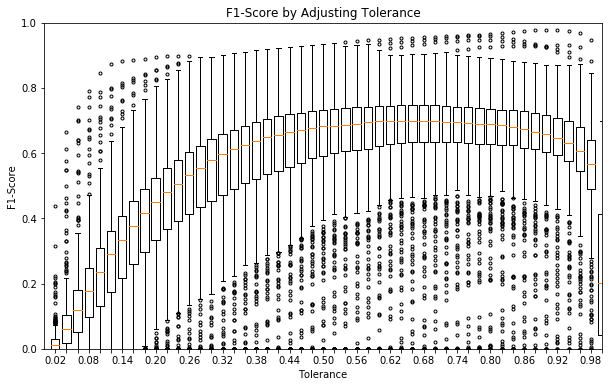

In [9]:
from matplotlib.ticker import FuncFormatter

def format_ticks(x, pos):
    return f'{x:.2f}' if pos % 3 == 0 else ''

fig, ax = plt.subplots(figsize=(10, 6))
plt.boxplot(list(results), positions=TOLERANCES, widths=0.015, sym='.')
ax.set_ylim([0, 1])
ax.set_xlim([0, 1])
ax.set_xlabel('Tolerance')
ax.set_ylabel('F1-Score')
ax.set_title('F1-Score by Adjusting Tolerance')
plt.gca().xaxis.set_major_formatter(FuncFormatter(format_ticks))
plt.show()

In [10]:
third = lambda value: value[2]

tolerance_populations = [(f'{tolerance:.2f}', np.median(scores), np.std(scores))
                         for tolerance, scores in zip(TOLERANCES, results)]

min(topk(5, tolerance_populations, key=second), key=third)

('0.70', 0.69740593, 0.17222647)